In [116]:
%pylab inline

import pandas as pd
import numpy as np

# for calculating accurate distances betwen lat/long points
from geopy.distance import vincenty

from scipy.spatial import Voronoi, voronoi_plot_2d

from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [117]:
# import data
mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")

train = pd.read_csv('../input/train.csv')[['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent']]
test = pd.read_csv('../input/test.csv')[['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy']]

weather = pd.read_csv('../input/weather.csv')[['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']]

In [208]:
# precompute trap counts
traps = np.unique(train['Trap'])
n_traps = traps.size
trap_count = np.empty(n_traps, dtype=int)
for i in range(n_traps):
    trap_count[i] = train[(train.Trap == traps[i]) & (train.WnvPresent == 1)].as_matrix().shape[0]
#print sum(trap_count)
trap_dict = dict(zip(traps, trap_count))
#print trap_dict

# get species info
species = np.unique(train['Species'])
n_species = species.size
#print species

In [207]:
# generate features
n_features = 4 + n_species
X_train = np.empty((m_train, n_features), dtype=float64)
y_train = train[['WnvPresent']].as_matrix()

# reference lat/long for chicago
ll_chicago = (41.8369, -87.6847)

# data header
header = np.hstack((np.array(['dx', 'dy', 'dt', 'tc']), species))

for i in range(m_train):
    x = train.iloc[i]
    ll = x[['Latitude', 'Longitude']].as_matrix()
    d = x['Date']
    s = x['Species']
    t = x['Trap']
    
    # get dx and dy
    dx = vincenty(ll_chicago, (ll_chicago[0], ll[1])).meters
    if(ll_chicago[1] > ll[1]):
       dx *= -1
    dy = vincenty(ll_chicago, (ll[0], ll_chicago[1])).meters
    if(ll_chicago[0] > ll[0]):
       dy *= -1
    
    # get day of year
    d1 = datetime.strptime(d, "%Y-%m-%d")
    d0 = datetime.strptime(str(d1.year) + "-01-01", "%Y-%m-%d")
    dt = abs((d1 - d0).days)
    
    # get trap count
    tc = trap_dict[t]
    
    # get species array
    sa = np.array(s == species).astype(int)
    
    X_train[i, :] = np.hstack((np.array([dx, dy, dt, tc]), sa))

In [206]:
# output csv
train_df = pd.DataFrame(np.hstack((y_train, X_train)), columns=np.hstack(('label', header)))
train_df.to_csv('../working/train_f.csv')

(551, 12)


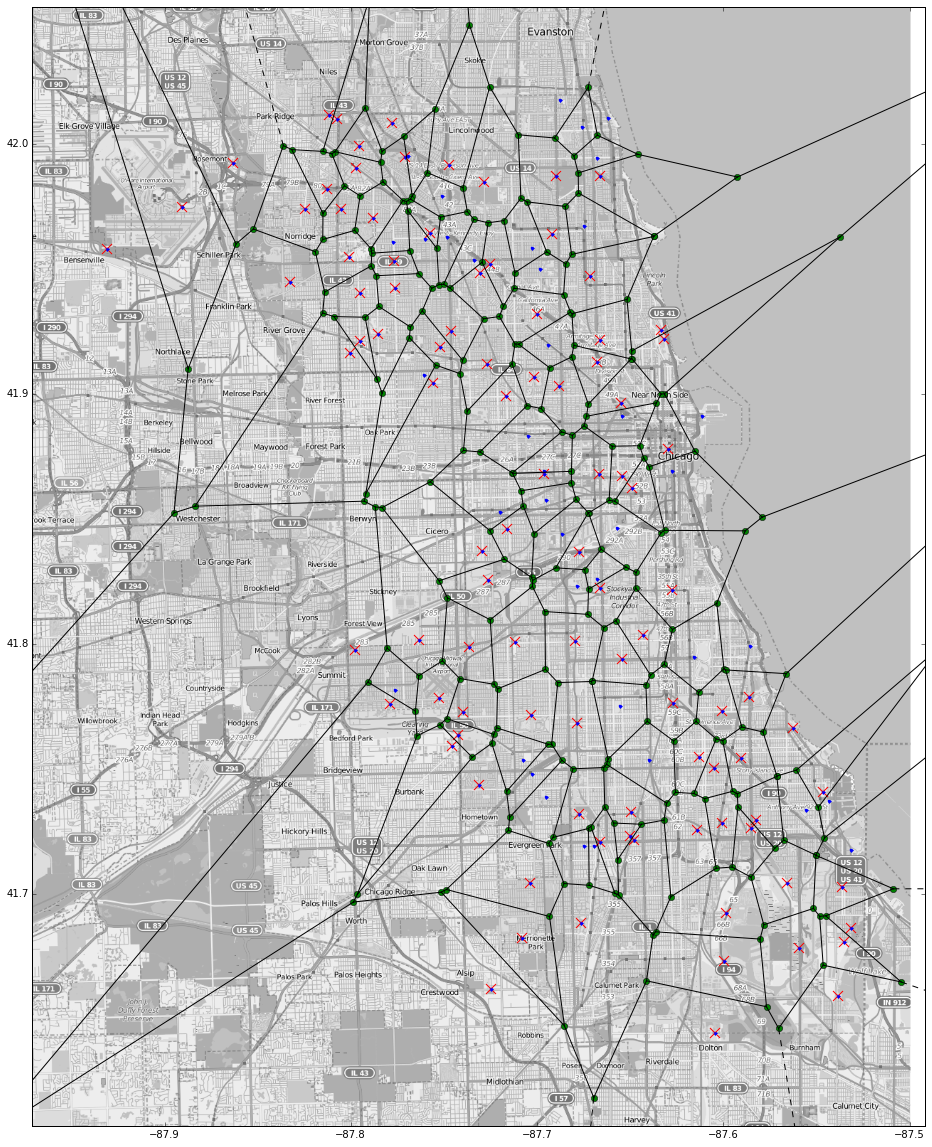

In [169]:
# generate map
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

fig, ax = plt.subplots()
fig.set_size_inches(16, aspect*16)

ax.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)

train_loc = train[['Longitude', 'Latitude']].drop_duplicates().values
ax.scatter(train_loc[:,0], train_loc[:,1], marker='.', color='b', s=10)

wnv_present = train[train.WnvPresent > 0]
print wnv_present.shape
wnv_loc = wnv_present[['Longitude', 'Latitude']].drop_duplicates().values
ax.scatter(wnv_loc[:,0], wnv_loc[:,1], marker='x', color='r', s=100)

train_vor = Voronoi(train_loc)
voronoi_plot_2d(train_vor, ax=ax)

plt.show()